In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

## Fuzzy Variables 

In [2]:
# Defining the scope of variables
soil_moisture_range = np.arange(0, 101, 1)
weather_range = np.arange(0, 11, 1)
irrigation_range = np.arange(0, 11, 1)

# Antecedents (Inputs) - Used by all systems initially
soil_moisture_orig = ctrl.Antecedent(soil_moisture_range, 'soil_moisture_orig')
weather_orig = ctrl.Antecedent(weather_range, 'weather_orig')

# Consequent (Output) - Using Centroid for the main simulation (Original System)
irrigation_centroid = ctrl.Consequent(irrigation_range, 'irrigation_centroid', defuzzify_method='centroid')

## Membership Functions

In [3]:
# Membership Functions for Soil Moisture (Original)
soil_moisture_orig['dry'] = fuzz.trimf(soil_moisture_orig.universe, [0, 0, 40])
soil_moisture_orig['medium'] = fuzz.trimf(soil_moisture_orig.universe, [20, 50, 80])
soil_moisture_orig['moist'] = fuzz.trimf(soil_moisture_orig.universe, [60, 100, 100])

# Membership Functions for Weather (Original)
weather_orig['sunny'] = fuzz.trimf(weather_orig.universe, [0, 0, 4])
weather_orig['cloudy'] = fuzz.trimf(weather_orig.universe, [2, 5, 8])
weather_orig['rainy'] = fuzz.trimf(weather_orig.universe, [6, 10, 10])

# Membership Functions for Irrigation Amount (shared shape for all methods initially)
irrigation_mfs_orig = {
    'no_water': fuzz.trimf(irrigation_range, [0, 0, 2]),
    'low': fuzz.trimf(irrigation_range, [1, 3, 5]),
    'medium': fuzz.trimf(irrigation_range, [4, 6, 8]),
    'high': fuzz.trimf(irrigation_range, [7, 10, 10])
}

# Assign MFs to the centroid consequent
for label, mf in irrigation_mfs_orig.items():
    irrigation_centroid[label] = mf

#### Visualize Membership Functions

C:\Users\emertat\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0.5, 1.0, 'Irrigation Amount Membership Functions (Centroid - Original)')

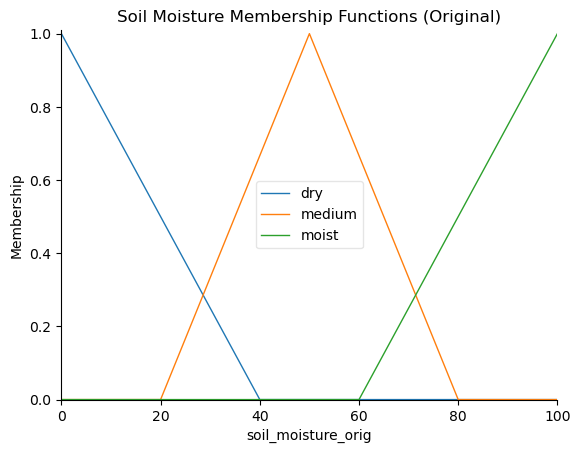

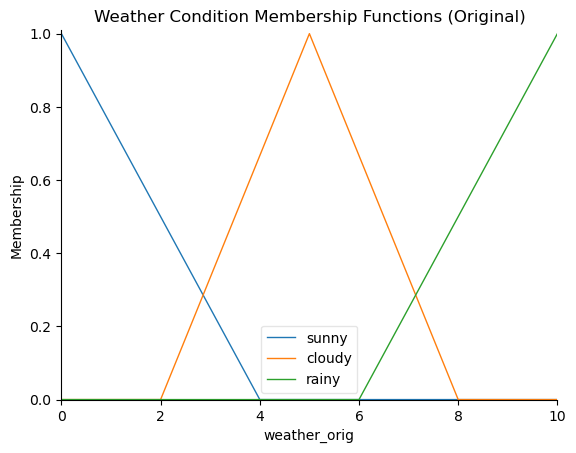

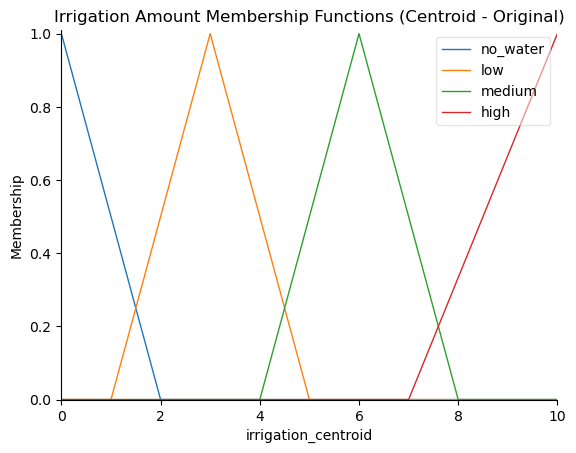

In [4]:
soil_moisture_orig.view() 
plt.title('Soil Moisture Membership Functions (Original)')
weather_orig.view()
plt.title('Weather Condition Membership Functions (Original)')
irrigation_centroid.view()
plt.title('Irrigation Amount Membership Functions (Centroid - Original)')

## Control Rules
- Define Control Rules (Original - 9 Rules)
- Create Control System for Centroid


In [5]:
rule1 = ctrl.Rule(soil_moisture_orig['dry'] & weather_orig['sunny'], irrigation_centroid['high'])
rule2 = ctrl.Rule(soil_moisture_orig['dry'] & weather_orig['cloudy'], irrigation_centroid['medium'])
rule3 = ctrl.Rule(soil_moisture_orig['dry'] & weather_orig['rainy'], irrigation_centroid['low'])
rule4 = ctrl.Rule(soil_moisture_orig['medium'] & weather_orig['sunny'], irrigation_centroid['medium'])
rule5 = ctrl.Rule(soil_moisture_orig['medium'] & weather_orig['cloudy'], irrigation_centroid['low'])
rule6 = ctrl.Rule(soil_moisture_orig['medium'] & weather_orig['rainy'], irrigation_centroid['no_water'])
rule7 = ctrl.Rule(soil_moisture_orig['moist'] & weather_orig['sunny'], irrigation_centroid['low'])
rule8 = ctrl.Rule(soil_moisture_orig['moist'] & weather_orig['cloudy'], irrigation_centroid['no_water'])
rule9 = ctrl.Rule(soil_moisture_orig['moist'] & weather_orig['rainy'], irrigation_centroid['no_water'])

rules_original = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]

irrigation_ctrl_original = ctrl.ControlSystem(rules_original)
irrigation_simulation_original = ctrl.ControlSystemSimulation(irrigation_ctrl_original)

### Alternative Defuzzification Methods
- Implement and Compare Alternative Defuzzification Methods
- Using the ORIGINAL 9-Rule structure for this comparison
- bisector - mom (Mean of Maximum) - lom (Largest of Maximum)

In [6]:
# Define Consequents for other methods
irrigation_bisector = ctrl.Consequent(irrigation_range, 'irrigation_bisector', defuzzify_method='bisector')
irrigation_mom = ctrl.Consequent(irrigation_range, 'irrigation_mom', defuzzify_method='mom')
irrigation_lom = ctrl.Consequent(irrigation_range, 'irrigation_lom', defuzzify_method='lom')


# Assign the same original membership function shapes to the new consequents
for label, mf in irrigation_mfs_orig.items():
    irrigation_bisector[label] = mf
    irrigation_mom[label] = mf
    irrigation_lom[label] = mf

# FIX for AttributeError: Access label via term.term.label
def create_rules_for_consequent(original_rules, new_consequent):
    new_rules = []
    for rule in original_rules:
        original_consequent_term = rule.consequent[0].term # Get the base Term
        new_rules.append(ctrl.Rule(rule.antecedent, new_consequent[original_consequent_term.label]))
    return new_rules

rules_bisector = create_rules_for_consequent(rules_original, irrigation_bisector)
rules_mom = create_rules_for_consequent(rules_original, irrigation_mom)
rules_lom = create_rules_for_consequent(rules_original, irrigation_lom)

# Create Control Systems and Simulations for each method
irrigation_ctrl_bisector = ctrl.ControlSystem(rules_bisector)
irrigation_simulation_bisector = ctrl.ControlSystemSimulation(irrigation_ctrl_bisector)

irrigation_ctrl_mom = ctrl.ControlSystem(rules_mom)
irrigation_simulation_mom = ctrl.ControlSystemSimulation(irrigation_ctrl_mom)

irrigation_ctrl_lom = ctrl.ControlSystem(rules_lom)
irrigation_simulation_lom = ctrl.ControlSystemSimulation(irrigation_ctrl_lom)

# --- Test Scenarios ---
test_inputs = [
    {'soil': 15, 'weather': 1, 'desc': 'Dry Soil, Sunny Weather'},
    {'soil': 30, 'weather': 5, 'desc': 'Dry Soil, Cloudy Weather'},
    {'soil': 50, 'weather': 5, 'desc': 'Medium Soil, Cloudy Weather'},
    {'soil': 75, 'weather': 9, 'desc': 'Moist Soil, Rainy Weather'},
    {'soil': 55, 'weather': 2, 'desc': 'Medium Soil, Sunny Weather'}
]

print("Comparing Defuzzification Outputs for Test Inputs:")
print("-" * 60)
print(f"{'Scenario':<30} | {'Centroid':>8} | {'Bisector':>8} | {'MoM':>8} | {'LoM':>8}")
print("-" * 60)

for inputs in test_inputs:
    simulations = {
        'Centroid': irrigation_simulation_original,
        'Bisector': irrigation_simulation_bisector,
        'MoM': irrigation_simulation_mom,
        'LoM': irrigation_simulation_lom,
    }
    outputs = {}

    for name, sim in simulations.items():
        sim.input['soil_moisture_orig'] = inputs['soil']
        sim.input['weather_orig'] = inputs['weather']

        sim.compute()
        first_consequent = next(iter(sim.ctrl.consequents))
        output_label = first_consequent.label
        outputs[name] = sim.output[output_label]



    print(f"{inputs['desc']:<30} | {outputs.get('Centroid', 0.0):>8.2f} | {outputs.get('Bisector', 0.0):>8.2f} | {outputs.get('MoM', 0.0):>8.2f} |"
          f" {outputs.get('LoM', 0.0):>8.2f}")

print("-" * 60)


Comparing Defuzzification Outputs for Test Inputs:
------------------------------------------------------------
Scenario                       | Centroid | Bisector |      MoM |      LoM
------------------------------------------------------------
Dry Soil, Sunny Weather        |     8.90 |     8.97 |     9.29 |    10.00
Dry Soil, Cloudy Weather       |     4.31 |     4.12 |     3.33 |     4.33
Medium Soil, Cloudy Weather    |     3.00 |     3.00 |     3.00 |     3.00
Moist Soil, Rainy Weather      |     0.83 |     0.81 |     0.75 |     1.25
Medium Soil, Sunny Weather     |     6.00 |     6.00 |     6.00 |     7.00
------------------------------------------------------------


### Define Enhanced System (15 Rules)

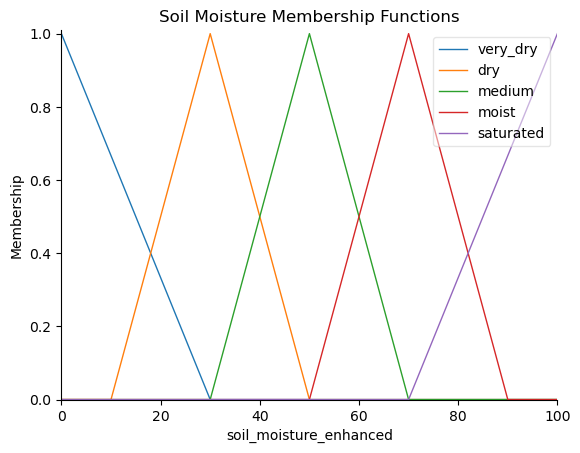

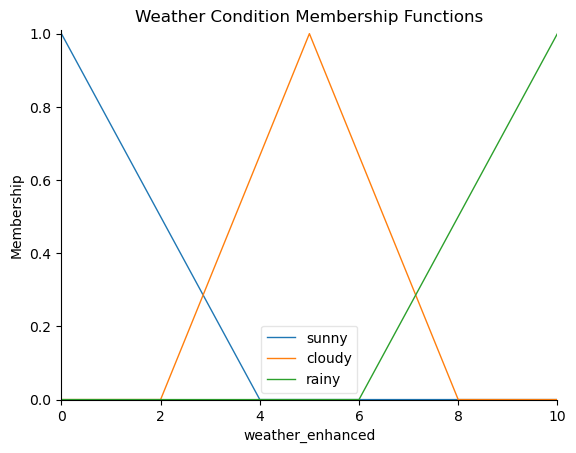

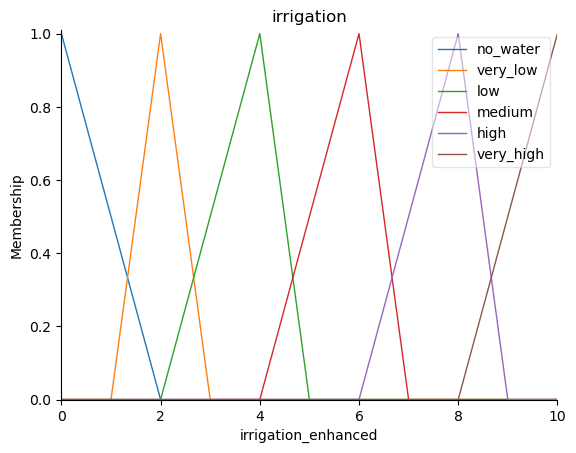

In [7]:
soil_moisture_enhanced = ctrl.Antecedent(soil_moisture_range, 'soil_moisture_enhanced')
weather_enhanced = ctrl.Antecedent(weather_range, 'weather_enhanced') 
irrigation_enhanced = ctrl.Consequent(irrigation_range, 'irrigation_enhanced', defuzzify_method='centroid')

# Enhanced Membership Functions
soil_moisture_enhanced['very_dry'] = fuzz.trimf(soil_moisture_enhanced.universe, [0, 0, 30])
soil_moisture_enhanced['dry'] = fuzz.trimf(soil_moisture_enhanced.universe, [10, 30, 50])
soil_moisture_enhanced['medium'] = fuzz.trimf(soil_moisture_enhanced.universe, [30, 50, 70])
soil_moisture_enhanced['moist'] = fuzz.trimf(soil_moisture_enhanced.universe, [50, 70, 90])
soil_moisture_enhanced['saturated'] = fuzz.trimf(soil_moisture_enhanced.universe, [70, 100, 100])


# Reusing original weather MFs for simplicity, assigning to new variable
weather_enhanced['sunny'] = weather_orig['sunny'].mf
weather_enhanced['cloudy'] = weather_orig['cloudy'].mf
weather_enhanced['rainy'] = weather_orig['rainy'].mf

irrigation_enhanced['no_water'] = fuzz.trimf(irrigation_enhanced.universe, [0, 0, 2])
irrigation_enhanced['very_low'] = fuzz.trimf(irrigation_enhanced.universe, [1, 2, 3])
irrigation_enhanced['low'] = fuzz.trimf(irrigation_enhanced.universe, [2, 4, 5])
irrigation_enhanced['medium'] = fuzz.trimf(irrigation_enhanced.universe, [4, 6, 7])
irrigation_enhanced['high'] = fuzz.trimf(irrigation_enhanced.universe, [6, 8, 9])
irrigation_enhanced['very_high'] = fuzz.trimf(irrigation_enhanced.universe, [8, 10, 10])


soil_moisture_enhanced.view() 
plt.title('Soil Moisture Membership Functions')
weather_enhanced.view()
plt.title('Weather Condition Membership Functions')
irrigation_enhanced.view()
plt.title('irrigation')
plt.show()

In [8]:
# Define individual rules for the enhanced system
rule_e1 = ctrl.Rule(soil_moisture_enhanced['very_dry'] & weather_enhanced['sunny'], irrigation_enhanced['very_high'])
rule_e2 = ctrl.Rule(soil_moisture_enhanced['very_dry'] & weather_enhanced['cloudy'], irrigation_enhanced['high'])
rule_e3 = ctrl.Rule(soil_moisture_enhanced['very_dry'] & weather_enhanced['rainy'], irrigation_enhanced['low'])
rule_e4 = ctrl.Rule(soil_moisture_enhanced['dry'] & weather_enhanced['sunny'], irrigation_enhanced['high'])
rule_e5 = ctrl.Rule(soil_moisture_enhanced['dry'] & weather_enhanced['cloudy'], irrigation_enhanced['medium'])
rule_e6 = ctrl.Rule(soil_moisture_enhanced['dry'] & weather_enhanced['rainy'], irrigation_enhanced['very_low'])
rule_e7 = ctrl.Rule(soil_moisture_enhanced['medium'] & weather_enhanced['sunny'], irrigation_enhanced['medium'])
rule_e8 = ctrl.Rule(soil_moisture_enhanced['medium'] & weather_enhanced['cloudy'], irrigation_enhanced['low'])
rule_e9 = ctrl.Rule(soil_moisture_enhanced['medium'] & weather_enhanced['rainy'], irrigation_enhanced['no_water'])
rule_e10 = ctrl.Rule(soil_moisture_enhanced['moist'] & weather_enhanced['sunny'], irrigation_enhanced['low'])
rule_e11 = ctrl.Rule(soil_moisture_enhanced['moist'] & weather_enhanced['cloudy'], irrigation_enhanced['very_low'])
rule_e12 = ctrl.Rule(soil_moisture_enhanced['moist'] & weather_enhanced['rainy'], irrigation_enhanced['no_water'])
rule_e13 = ctrl.Rule(soil_moisture_enhanced['saturated'] & weather_enhanced['sunny'], irrigation_enhanced['no_water'])
rule_e14 = ctrl.Rule(soil_moisture_enhanced['saturated'] & weather_enhanced['cloudy'], irrigation_enhanced['no_water'])
rule_e15 = ctrl.Rule(soil_moisture_enhanced['saturated'] & weather_enhanced['rainy'], irrigation_enhanced['no_water'])

# Collect the individual rules into the rules_enhanced list
rules_enhanced = [
    rule_e1, rule_e2, rule_e3, rule_e4, rule_e5, rule_e6,
    rule_e7, rule_e8, rule_e9, rule_e10, rule_e11, rule_e12,
    rule_e13, rule_e14, rule_e15
]


# Create Control System for Enhanced System
irrigation_ctrl_enhanced = ctrl.ControlSystem(rules_enhanced)
irrigation_simulation_enhanced = ctrl.ControlSystemSimulation(irrigation_ctrl_enhanced)

# Simulation and Analysis
- Comparing Original 9-Rule vs Enhanced 15-Rule


Simulation Parameters

In [9]:
initial_moisture = 20
days = 10
weather_sequence_continuous = np.array([0.5, 1.5, 4.0, 6.0, 8.5, 9.5, 7.0, 3.0, 1.0, 5.5])
weather_points = [0.0, 5.0, 10.0]
effect_points = [-5.0, -2.0, 5.0]
optimal_range_lower = 35
optimal_range_upper = 65

In [10]:
# Calculates the effect of weather on soil moisture using interpolation.
def calculate_weather_effect(weather_value):
  return np.interp(weather_value, weather_points, effect_points)

###  Simulation 1: Original System (9 Rules)

In [11]:
moisture_levels_original = [initial_moisture]
irrigation_amounts_original = []
current_moisture = initial_moisture

print(f"Day 0: Initial Moisture = {current_moisture:.2f}%")
print("-" * 70)
print(f"{'Day':>3} | {'Weather Val':>11} | {'Moisture In':>12} | {'Irrigation':>10} | {'Weather Effect':>15} | {'Moisture Out':>13}")
print("-" * 70)

for day in range(days):
    current_weather_continuous = weather_sequence_continuous[day]
    moisture_before_irrigation = current_moisture

    irrigation_simulation_original.input['soil_moisture_orig'] = current_moisture
    irrigation_simulation_original.input['weather_orig'] = current_weather_continuous

    irrigation_simulation_original.compute()
    irrigation_output = irrigation_simulation_original.output['irrigation_centroid']

    irrigation_amounts_original.append(irrigation_output)
    weather_effect_value = calculate_weather_effect(current_weather_continuous)

    current_moisture = current_moisture + (0.6 * irrigation_output) + weather_effect_value
    current_moisture = np.clip(current_moisture, 0, 100)
    moisture_levels_original.append(current_moisture)

    print(f"{day + 1:>3} | {current_weather_continuous:>11.1f} | {moisture_before_irrigation:>12.2f} | {irrigation_output:>10.2f} |"
          f" {weather_effect_value:>+15.1f} | {current_moisture:>13.2f}")

print("-" * 70)

Day 0: Initial Moisture = 20.00%
----------------------------------------------------------------------
Day | Weather Val |  Moisture In | Irrigation |  Weather Effect |  Moisture Out
----------------------------------------------------------------------
  1 |         0.5 |        20.00 |       8.83 |            -4.7 |         20.60
  2 |         1.5 |        20.60 |       8.64 |            -4.1 |         21.69
  3 |         4.0 |        21.69 |       5.61 |            -2.6 |         22.46
  4 |         6.0 |        22.46 |       5.46 |            -0.6 |         25.13
  5 |         8.5 |        25.13 |       2.63 |            +2.9 |         29.61
  6 |         9.5 |        29.61 |       2.26 |            +4.3 |         35.27
  7 |         7.0 |        35.27 |       3.28 |            +0.8 |         38.04
  8 |         3.0 |        38.04 |       4.57 |            -3.2 |         37.58
  9 |         1.0 |        37.58 |       6.23 |            -4.4 |         36.91
 10 |         5.5 |      

### Simulation 2: Enhanced System (15 Rules)

In [12]:
moisture_levels_enhanced = [initial_moisture]
irrigation_amounts_enhanced = []
current_moisture = initial_moisture # Reset moisture
print(f"Day 0: Initial Moisture = {current_moisture:.2f}%")
print("-" * 70)
print(f"{'Day':>3} | {'Weather Val':>11} | {'Moisture In':>12} | {'Irrigation':>10} | {'Weather Effect':>15} | {'Moisture Out':>13}")
print("-" * 70)

for day in range(days):
    current_weather_continuous = weather_sequence_continuous[day]
    moisture_before_irrigation = current_moisture

    irrigation_simulation_enhanced.input['soil_moisture_enhanced'] = current_moisture
    irrigation_simulation_enhanced.input['weather_enhanced'] = current_weather_continuous

    try:
      irrigation_simulation_enhanced.compute()
      irrigation_output = irrigation_simulation_enhanced.output['irrigation_enhanced']
    except ValueError:
       irrigation_output = 0.0
       print(f"Warning: Day {day + 1} Enh - Could not compute irrigation. Setting to 0.")

    irrigation_amounts_enhanced.append(irrigation_output)
    weather_effect_value = calculate_weather_effect(current_weather_continuous)

    current_moisture = current_moisture + (0.6 * irrigation_output) + weather_effect_value
    current_moisture = np.clip(current_moisture, 0, 100)
    moisture_levels_enhanced.append(current_moisture)

    print(f"{day + 1:>3} | {current_weather_continuous:>11.1f} | {moisture_before_irrigation:>12.2f} | {irrigation_output:>10.2f} |"
          f" {weather_effect_value:>+15.1f} | {current_moisture:>13.2f}")

print("-" * 70)

Day 0: Initial Moisture = 20.00%
----------------------------------------------------------------------
Day | Weather Val |  Moisture In | Irrigation |  Weather Effect |  Moisture Out
----------------------------------------------------------------------
  1 |         0.5 |        20.00 |       8.07 |            -4.7 |         20.95
  2 |         1.5 |        20.95 |       8.03 |            -4.1 |         22.47
  3 |         4.0 |        22.47 |       6.27 |            -2.6 |         24.26
  4 |         6.0 |        24.26 |       6.16 |            -0.6 |         27.97
  5 |         8.5 |        27.97 |       2.28 |            +2.9 |         32.47
  6 |         9.5 |        32.47 |       1.81 |            +4.3 |         38.03
  7 |         7.0 |        38.03 |       3.63 |            +0.8 |         41.37
  8 |         3.0 |        41.37 |       5.41 |            -3.2 |         41.96
  9 |         1.0 |        41.96 |       6.48 |            -4.4 |         42.09
 10 |         5.5 |      

### Comparison Metrics

In [13]:
print("Comparison Metrics (9 Rules vs 15 Rules): ")
avg_moisture_orig = np.mean(moisture_levels_original[1:])
avg_moisture_enhanced = np.mean(moisture_levels_enhanced[1:])
total_irrigation_orig = np.sum(irrigation_amounts_original)
total_irrigation_enhanced = np.sum(irrigation_amounts_enhanced)
moisture_end_of_day_orig = moisture_levels_original[1:]
moisture_end_of_day_enhanced = moisture_levels_enhanced[1:]
days_in_optimal_orig = sum(optimal_range_lower <= m <= optimal_range_upper for m in moisture_end_of_day_orig)
days_in_optimal_enhanced = sum(optimal_range_lower <= m <= optimal_range_upper for m in moisture_end_of_day_enhanced)
percent_in_optimal_orig = (days_in_optimal_orig / days) * 100
percent_in_optimal_enhanced = (days_in_optimal_enhanced / days) * 100

print(f"Metric\t\t\t| Original (9R)\t| Enhanced (15R)")
print(f"------------------------|---------------|----------------")
print(f"Avg Moisture (%)\t| {avg_moisture_orig:.2f}\t\t| {avg_moisture_enhanced:.2f}")
print(f"Total Irrigation (unit)\t| {total_irrigation_orig:.2f}\t\t| {total_irrigation_enhanced:.2f}")
print(f"Days in Optimal\t\t| {days_in_optimal_orig}\t\t| {days_in_optimal_enhanced}")
print(f"Percent in Optimal (%)\t| {percent_in_optimal_orig:.1f}\t\t| {percent_in_optimal_enhanced:.1f}")


Comparison Metrics (9 Rules vs 15 Rules): 
Metric			| Original (9R)	| Enhanced (15R)
------------------------|---------------|----------------
Avg Moisture (%)	| 30.50		| 33.55
Total Irrigation (unit)	| 50.96		| 52.60
Days in Optimal		| 5		| 5
Percent in Optimal (%)	| 50.0		| 50.0


### Plotting Comparison

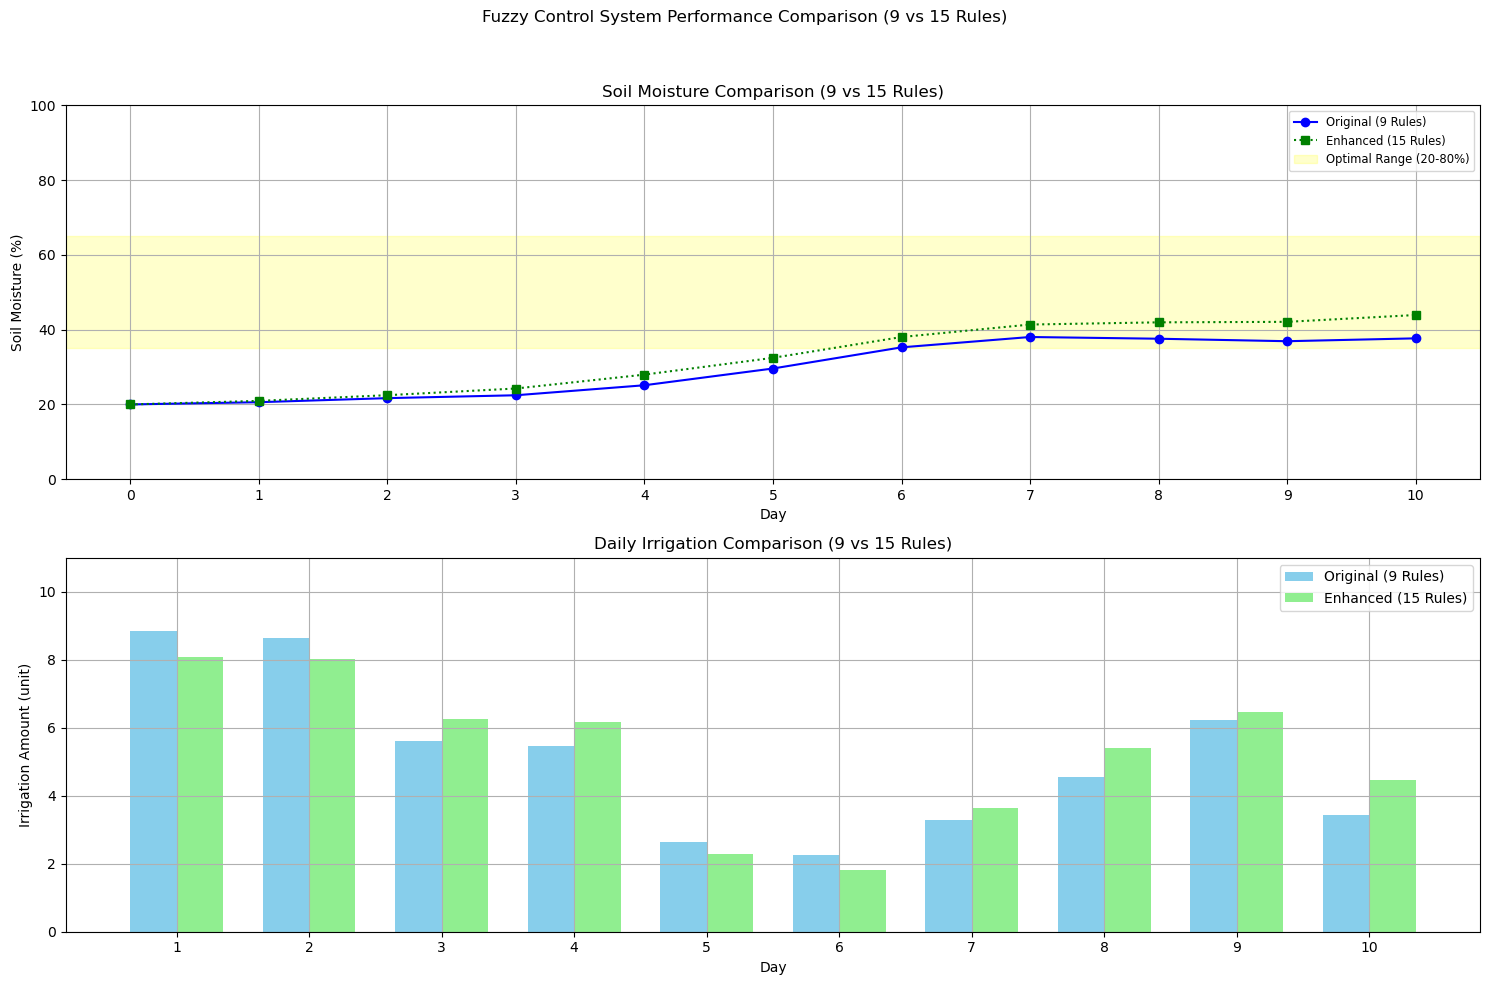

In [14]:
time_axis = np.arange(days + 1)
irrigation_time_axis = np.arange(days) + 1

plt.figure(figsize=(15, 10))

# Moisture Comparison Plot
plt.subplot(2, 1, 1)
plt.plot(time_axis, moisture_levels_original, marker='o', linestyle='-', color='b', label='Original (9 Rules)')
plt.plot(time_axis, moisture_levels_enhanced, marker='s', linestyle=':', color='g', label="Enhanced (15 Rules)")
plt.title('Soil Moisture Comparison (9 vs 15 Rules)')
plt.xlabel('Day')
plt.ylabel('Soil Moisture (%)')
plt.xticks(time_axis)
plt.ylim(0, 100)
plt.axhspan(optimal_range_lower, optimal_range_upper, color='yellow', alpha=0.2, label='Optimal Range (20-80%)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Irrigation Comparison Plot
plt.subplot(2, 1, 2)
bar_width = 0.35
plt.bar(irrigation_time_axis - bar_width/2, irrigation_amounts_original, width=bar_width, color='skyblue', label='Original (9 Rules)')
plt.bar(irrigation_time_axis + bar_width/2, irrigation_amounts_enhanced, width=bar_width, color='lightgreen', label="Enhanced (15 Rules)")
plt.title('Daily Irrigation Comparison (9 vs 15 Rules)')
plt.xlabel('Day')
plt.ylabel('Irrigation Amount (unit)')
plt.xticks(irrigation_time_axis)

# Adjust ylim dynamically based on max irrigation in either simulation
max_irrigation = 0
if irrigation_amounts_original:
    max_irrigation = max(max_irrigation, max(irrigation_amounts_original))
if irrigation_amounts_enhanced:
     max_irrigation = max(max_irrigation, max(irrigation_amounts_enhanced))
plt.ylim(0, max(irrigation_range.max(), max_irrigation) + 1)
plt.legend(loc='upper right')
plt.grid(True)

plt.suptitle("Fuzzy Control System Performance Comparison (9 vs 15 Rules)", y=1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()